In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import torch
from torch_geometric.data import Data, Dataset
from torch_geometric.utils import to_networkx
from torch_geometric.nn.models import Node2Vec
import numpy as np

In [2]:
def create_cycle_graph(n_nodes):
    edge_index = [[i, (i + 1) % n_nodes] for i in range(n_nodes)] + [
        [(i + 1) % n_nodes, i] for i in range(n_nodes)
    ]
    return Data(
        edge_index=torch.tensor(edge_index).t().contiguous(),
        y=torch.tensor([0]),
        num_nodes=n_nodes,
        nodes_classes=torch.arange(n_nodes).unsqueeze(1),
    )


def create_complete_graph(n_nodes):
    edge_index = [[i, j] for i in range(n_nodes) for j in range(n_nodes) if i != j]
    return Data(
        edge_index=torch.tensor(edge_index).t().contiguous(),
        y=torch.tensor([1]),
        num_nodes=n_nodes,
        nodes_classes=torch.arange(n_nodes).unsqueeze(1),
    )


def create_line_graph(n_nodes):
    edge_index = [[i, i + 1] for i in range(n_nodes - 1)] + [
        [i + 1, i] for i in range(n_nodes - 1)
    ]
    return Data(
        edge_index=torch.tensor(edge_index).t().contiguous(),
        y=torch.tensor([2]),
        num_nodes=n_nodes,
        nodes_classes=torch.arange(n_nodes).unsqueeze(1),
    )


def create_star_graph(n_leaves):
    n_leaves -= 1
    edge_index = [[0, i] for i in range(1, n_leaves + 1)] + [
        [i, 0] for i in range(1, n_leaves + 1)
    ]
    return Data(
        edge_index=torch.tensor(edge_index).t().contiguous(),
        y=torch.tensor([3]),
        num_nodes=n_leaves + 1,
        nodes_classes=torch.arange(n_leaves + 1).unsqueeze(1),
    )


# def create_wheel_graph(n_nodes):
#     edges = []
#     for i in range(1, n_nodes):
#         edges.append([0, i])
#         edges.append([i, i % (n_nodes - 1) + 1])
#     edges += [[j, i] for i, j in edges]
#     edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

#     return Data(
#         edge_index=edge_index,
#         y=torch.tensor([4]),
#         num_nodes=n_nodes,
#         nodes_classes=torch.arange(n_nodes).unsqueeze(1),
#     )

In [3]:
def plot_graph(data, original_pos=None):
    G = to_networkx(data, to_undirected=True)
    plt.figure(figsize=(5, 5))

    new_pos = None

    if original_pos is not None:
        new_pos = nx.spring_layout(G)
        original_pos.update({n: new_pos[n] for n in G.nodes() if n not in original_pos})
        pos = original_pos
    else:
        pos = nx.spring_layout(G)

    nx.draw(
        G,
        pos=pos,
        with_labels=False,
        node_color="skyblue",
        node_size=500,
        edge_color="k",
        linewidths=2,
        font_size=15,
    )
    plt.show()

    return pos

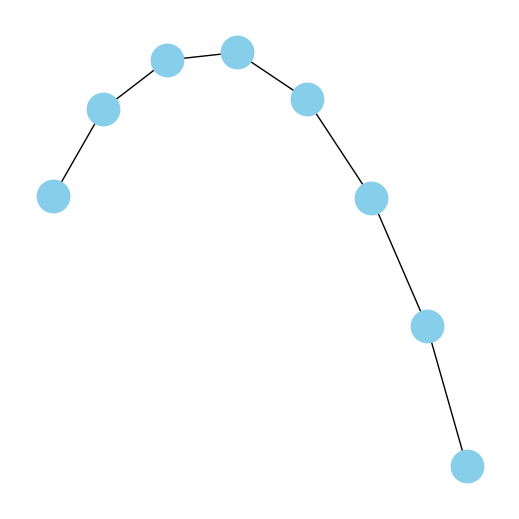

In [4]:
data = create_line_graph(8)
pos = plot_graph(data)

In [5]:
model = Node2Vec(
    data.edge_index,
    embedding_dim=128,
    walk_length=20,
    context_size=10,
    walks_per_node=10,
    num_negative_samples=1,
    p=1,
    q=1,
    sparse=True,
)

Data(x=[10, 4], edge_index=[2, 22], y=[1], num_nodes=10, node_classes=[10])


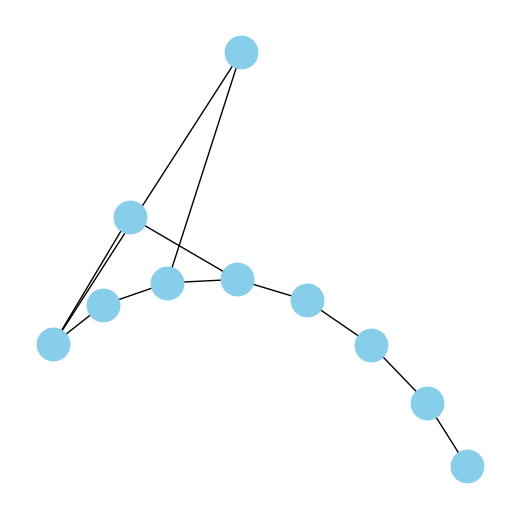

{0: array([ 0.93887218, -0.35393841]),
 1: array([ 0.75258205, -0.17559959]),
 2: array([ 0.49228482, -0.01198938]),
 3: array([0.18851095, 0.11371166]),
 4: array([-0.13934964,  0.17345269]),
 5: array([-0.46603323,  0.16365806]),
 6: array([-0.76686713,  0.10074915]),
 7: array([-1.        , -0.01004418]),
 8: array([-0.64282238,  0.35102183]),
 9: array([-0.11883987,  0.81618143])}

In [6]:
def add_noise_to_graph(graph, num_new_nodes, avg_new_edges_per_node=2):
    num_nodes = graph.num_nodes

    if hasattr(graph, "node_classes"):
        node_classes = graph.node_classes
    else:
        node_classes = [[i] for i in range(1, num_nodes + 1)]

    node_classes.extend([[] for _ in range(num_new_nodes)])

    new_edges_list = []
    current_total_nodes = num_nodes
    for new_node_id in range(num_nodes, num_nodes + num_new_nodes):
        if current_total_nodes > avg_new_edges_per_node:
            connections = np.random.choice(
                current_total_nodes, avg_new_edges_per_node, replace=False
            )
        else:
            connections = np.arange(current_total_nodes)

        new_node_class_set = set()

        for conn in connections:
            new_edges_list.append([new_node_id, conn])
            new_edges_list.append([conn, new_node_id])
            new_node_class_set.update(node_classes[conn])

        node_classes[new_node_id] = list(new_node_class_set)

        current_total_nodes += 1

    new_edges = torch.tensor(new_edges_list, dtype=torch.long).t()
    new_edge_index = torch.cat([graph.edge_index, new_edges], dim=1)

    new_x = torch.ones(current_total_nodes, 4)

    return Data(
        x=new_x,
        edge_index=new_edge_index,
        num_nodes=current_total_nodes,
        node_classes=node_classes,
        y=graph.y,
    )


new_graph = add_noise_to_graph(data, 2, 2)
print(new_graph)
plot_graph(new_graph, pos)

In [7]:
class GraphDataset(Dataset):
    def __init__(self, data_list):
        self.data_list = data_list
        self.name = "Synthetic"

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        return self.data_list[idx]

    def save(self, file_path):
        torch.save(self.data_list, file_path)

In [8]:
funcs = [
    create_complete_graph,
    create_cycle_graph,
    create_line_graph,
    create_star_graph,
    # create_wheel_graph,
]

nodes = [1, 2, 3]
edges = [2]


def add_node2vec_features(
    data_list,
    embedding_dim=8,
    walk_length=10,
    context_size=5,
    walks_per_node=20,
    num_negative_samples=2,
    batch_size=128,
    learning_rate=0.01,
    epochs=200,
):
    updated_data_list = []
    for data in data_list:
        if "edge_index" not in data:
            print("Graph does not contain edge_index.")
            continue

        model = Node2Vec(
            data.edge_index,
            embedding_dim=embedding_dim,
            walk_length=walk_length,
            context_size=context_size,
            walks_per_node=walks_per_node,
            num_negative_samples=num_negative_samples,
            sparse=True,
        )

        loader = model.loader(batch_size=batch_size, shuffle=True, num_workers=0)
        optimizer = torch.optim.SparseAdam(model.parameters(), lr=learning_rate)

        model.train()
        for epoch in range(epochs):
            total_loss = 0
            for pos_rw, neg_rw in loader:
                optimizer.zero_grad()
                loss = model.loss(pos_rw, neg_rw)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            print(f"Epoch: {epoch}, Loss: {total_loss / len(loader)}")

        model.eval()
        with torch.no_grad():
            embeddings = model()

        data.x = (
            torch.cat([data.x, embeddings], dim=1) if data.x is not None else embeddings
        )

        updated_data_list.append(data)
        # break

    return updated_data_list


def create_dataset():
    graphs = []
    for func in funcs:
        graph = func(8)
        for _ in range(10):
            for n in nodes:
                for e in edges:
                    noisy_graph = add_noise_to_graph(graph, n, e)
                    graphs.append(noisy_graph)
    # graphs = add_node2vec_features(graphs)
    return GraphDataset(graphs)


dataset = create_dataset()
dataset.save("data/cycle_line_star_complete_1.pt")